In [1]:
import yt
from yt import YTArray
from astropy import constants as const
import sys
import h5py as h5
import trident
import numpy as np
import os.path
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
import palettable
sns.set_style("white",{'font.family':'serif', 'text.usetex':True, 'axes.grid': True})
#for trident: git checkout 8b71bb81879a4d86b6d6c5e83c10971ece4e5d96
# for yt : git checkout ea857e75c2670fbb8f03de18017ff1a1b4a43e21
#sys.path.append('../analysis')
#import spectrum_generating_tools as spg

In [2]:
ds = yt.load('/Users/irynabutsky/simulations/patient0/pioneer.003195')
#trident.add_ion_fields(ds, ions = ['O VI', 'H I'])

# load in data of start and end coordinates of all the rays
ray_id, impact, bvx, bvy, bvz, xi, yi, zi, xf, yf, zf = np.loadtxt('../../data/P0_z0.25_ray_data.dat', skiprows = 1, unpack = True,\
                                                    usecols = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

# for annoying reasons... need to convert ray positions to "code units"
code_unit_conversion = ds.domain_right_edge.d / ds.domain_right_edge.in_units('kpc').d
start_pos = np.ndarray(shape=(0, 3))
end_pos = np.ndarray(shape=(0, 3))
for i in range(len(xi)):
    start_pos = np.vstack((start_pos, [xi[i], yi[i], zi[i]] * code_unit_conversion))
    end_pos = np.vstack((end_pos, [xf[i], yf[i], zf[i]] * code_unit_conversion))

ray_center = start_pos[10] + 0.5*(end_pos[10] - start_pos[10])
ray_direction = end_pos[10] - start_pos[10]
print(ray_center, ray_direction)

yt : [INFO     ] 2021-01-27 18:54:28,236 Parameters: current_time              = 3.3988696927205075e+17 s
yt : [INFO     ] 2021-01-27 18:54:28,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-01-27 18:54:28,238 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-01-27 18:54:28,238 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-01-27 18:54:28,239 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-01-27 18:54:28,240 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-01-27 18:54:28,240 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-01-27 18:54:28,241 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-01-27 18:54:28,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-01-27 18:54:28,242 Parameters: hubble_constant           = 0.677583430663222


[-0.42299158 -0.30013312  0.13297239] [ 0.00847311 -0.00861534 -0.0031907 ]


In [19]:
def plot_sightline_data(sim, ray_id, output = 3195):
    plot_data = h5.File('../../data/ray_files/ray_%s_%i_%i.h5'%(sim, output, ray_id), 'r')

    # see all of the available arrays in the file
    # naming convention: O_p5_number_density = O VI number density

    # Position along the ray (along the y-axis). 0 = cluster center
    print(plot_data.keys())
    l = np.array(plot_data['y'])
    temperature = np.array(plot_data['temperature'])
    density     = np.array(plot_data['density'])
    metallicity = np.array(plot_data['metallicity'])
    vlos        = np.array(plot_data['velocity_los'])
    # size of cell along sightline
    # need this to convert from ion number density to column density
    dl = np.array(plot_data['dl'])
    
    # O VI and H I column densities
    ocol = dl * np.array(plot_data['Si_p2_number_density'])
    hcol = dl * np.array(plot_data['H_number_density'])

    field_list = [temperature, density, metallicity, vlos, np.cumsum(hcol), np.cumsum(ocol)]
    ylim_list  = [(1e4, 1e7), (1e-30, 1e-23), (1e-4, 10), (-300, 300), (1e10, 1e20), (1e10, 1e16)]
    ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'H I Column Density (cm$^{-2}$)', 'O VI Column Density (cm$^{-2}$)']
    ylabel_list = ['Temperature', 'Density', 'Metallicity', 'LOS Velocity', 'H I Column', 'O VI column']
    
    print(len(field_list))
    fig, ax = plt.subplots(nrows = len(field_list), ncols = 1 , figsize = (6, len(field_list)*3),
                               sharex=True, sharey=False)
    for i in range(len(field_list)):
        if i > 3:
            label = 'Cumulative Column Density'
        else:
            label = None
        if i != 3:
        #    ax[i].set_yscale('log') 
            data = np.log10(field_list[i])
        else:
            data = field_list[i]
        ax[i].scatter(l, data, label = label)

        ax[i].set_xlim(0, 500)
#        ax[i].set_ylim(ylim_list[i])
        ax[i].set_ylabel(ylabel_list[i])
        
    ax[4].scatter(l, np.log10(hcol), label = 'Local Column Density')
    ax[5].scatter(l, np.log10(ocol), label = 'Local Column Density')
#    ax[len(field_list)-1].set_xlabel
    ax[0].set_xlabel('Lightray Trajectory (kpc)')
    ax[len(field_list)-1].legend()
    fig.tight_layout()
    plt.show()
    plt.savefig('../../plots/%s_z0.25_sightline_%i_multipanel.png'%(sim, ray_id))
#

In [20]:
#plot_sightline_data('P0', 69)
plot_sightline_data('P0_agncr', 36)

<KeysViewHDF5 ['C_p1_number_density', 'C_p2_number_density', 'C_p3_number_density', 'H_p0_number_density', 'N_p4_number_density', 'O_p5_number_density', 'Si_p1_number_density', 'Si_p2_number_density', 'Si_p3_number_density', 'density', 'dl', 'metallicity', 'temperature', 'y', 'y_lr']>


KeyError: "Unable to open object (object 'velocity_los' doesn't exist)"

In [4]:
def _los_vel(field, data):
    if data.has_field_parameter("bulk_velocity"):
        bv = data.get_field_parameter("bulk_velocity").in_units("km/s")
        print("heh", bv)
        sys.stdout.flush()
    else:
        print('wah')
        bv = data.ds.arr(np.zeros(3), "cm/s")
    vx = np.array((data[('gas', 'velocity_x')] - bv[0]).in_units('km/s'))
    vy = np.array((data[('gas', 'velocity_y')] - bv[1]).in_units('km/s'))
    vz = np.array((data[('gas', 'velocity_z')] - bv[2]).in_units('km/s'))
    
   # vel = np.column_stack((vx, vy, vz))
    if data.has_field_parameter("normal"):
        r_hat = data.get_field_parameter("normal")
        print("normal vector = ", r_hat)
    else:
        ('warning: no ray_norm')
        r_hat = [0, 0, 1]
        
    r_hat_mag = np.linalg.norm(r_hat)
    r_hat = np.divide(r_hat, r_hat_mag)
    
   # v_dot_rhat = np.dot(vel, r_hat) 
    v_dot_rhat = vx*r_hat[0] + vy*r_hat[1] + vz*r_hat[2]
    print(v_dot_rhat.shape)
    return YTArray(v_dot_rhat, 'km/s')

In [16]:
#ds = yt.load('/Users/irynabutsky/Work/galaxy/P0/P0.003195')
from yt.fields.api import ValidateParameter

#yt.add_field(('Gas', 'ray_los_velocity'), function = _los_vel, particle_type = True,
#             force_override = True, units = 'km/s', validators=[ValidateParameter(['normal', 'bulk_velocity'])])

In [5]:
ds = yt.load('/Users/irynabutsky/simulations/patient0/pioneer.003195')
ad = ds.all_data()
ad.set_field_parameter('bulk_velocity', YTArray([0, 0, 100], 'km/s'))
ad.set_field_parameter('normal', [0, 0, 1])
ds.add_field(('all', 'ray_los_velocity2'), function = _los_vel, particle_type = True,
             force_override = True, units = 'km/s', validators=[ValidateParameter(['normal', 'bulk_velocity'])])

code_unit_conversion = ds.domain_right_edge.d / ds.domain_right_edge.in_units('kpc').d

width = np.array([200., 10., 10.]) # kpc
width *= code_unit_conversion
print(width)
#image_test_bv_z = yt.off_axis_projection(ds, ray_center, ray_direction, width, 
#                                   [600, 30], ('all', 'ray_los_velocity2'),
#                               weight = ('gas', 'density'))
image_bv_z = yt.off_axis_projection(ds, ray_center, ray_direction, width, 
                                  [1200, 60], ('gas', 'velocity_z'),
                               weight = ('gas', 'density'))


yt : [INFO     ] 2021-01-27 11:38:24,085 Parameters: current_time              = 3.398869692720506e+17 s
yt : [INFO     ] 2021-01-27 11:38:24,086 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-01-27 11:38:24,087 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-01-27 11:38:24,088 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-01-27 11:38:24,089 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-01-27 11:38:24,090 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2021-01-27 11:38:24,090 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-01-27 11:38:24,091 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-01-27 11:38:24,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-01-27 11:38:24,092 Parameters: hubble_constant           = 0.677583430663222


NameError: name '_los_vel' is not defined

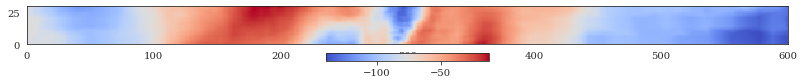

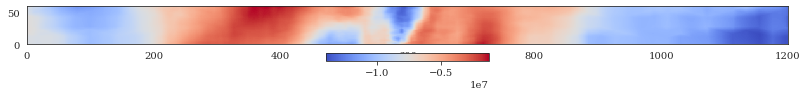

In [162]:
fig, ax = plt.subplots(1, 1, figsize = (20, 1))
im = ax.pcolormesh(image_test_bv_z.T, cmap = 'coolwarm')#, vmin = -200, vmax = 200)
cbar = fig.colorbar(im, ax=ax, orientation = 'horizontal')

ax.set_aspect('equal')

fig, ax = plt.subplots(1, 1, figsize = (20, 1))
im = ax.pcolormesh(image_vz.T, cmap = 'coolwarm')
cbar = fig.colorbar(im, ax=ax, orientation = 'horizontal')

ax.set_aspect('equal')

In [136]:
ad.field_parameters

{'center': YTArray([0., 0., 0.]) code_length,
 'bulk_velocity': [1, 1, 1],
 'bulk_magnetic_field': YTArray([0., 0., 0.]) G,
 'normal': YTArray([0., 0., 1.]) (dimensionless),
 'norm': [1, 0, 0]}

In [89]:
r_hat = np.array([1, 0, 1])
vx = np.array([1, 2, 3, 4])
vy = np.array([5, 6, 7, 8])
vz = np.array([9, 10, 11, 12])

vel = np.column_stack((vx, vy, vz))

v_dot_rhat = vx*r_hat[0] + vy*r_hat[1] + vz*r_hat[2]
vx *= r_hat[0]
vy *= r_hat[1]
vz *= r_hat[2]

print(len(vx), len(vy), len(vz))
#vel = np.column_stack((vx, vy, vz)
                      
v_dot_rhat = np.dot(vel, r_hat)
print((vel.shape))
print(v_dot_rhat)



4 4 4
(4, 3)
[10 12 14 16]


In [47]:
#ad = ds.all_data()
ds.add_field(('all', 'ray_los_velocity'), function = _los_vel4, particle_type = True,
             force_override = True, units = 'km/s')

wah
1.0
[0. 0. 1.] 1.0


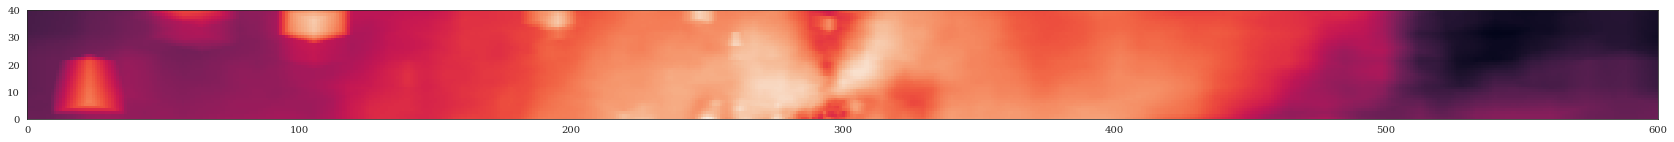

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (30, 2))
ax.pcolormesh(image2.T, norm = LogNorm())
ax.set_aspect('equal')

yt : [INFO     ] 2020-04-28 15:44:56,005 xlim = -0.006249 0.006249
yt : [INFO     ] 2020-04-28 15:44:56,006 ylim = -0.000250 0.000250
yt : [INFO     ] 2020-04-28 15:44:56,007 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



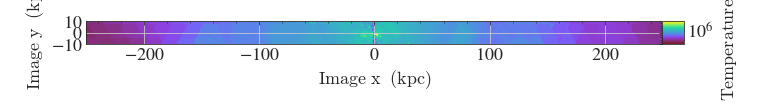

In [21]:
s = yt.OffAxisSlicePlot(ds, [1, 1, 1], ('gas', 'temperature'), center = gcenter, width = ((300, 'kpc'), (20, 'kpc')))
s.show()

In [5]:
import palettable
def get_cmap(field):
    if field =='density':
        cmap = palettable.cmocean.sequential.Tempo_20.mpl_colormap
    elif field == 'pressure':
        cmap = 'magma'
    elif field == 'temperature':
        cmap = palettable.scientific.sequential.LaJolla_20_r.mpl_colormap
    elif field == 'cr_eta':
        cmap = palettable.scientific.sequential.Tokyo_20.mpl_colormap
    elif field == 'cr_pressure':
        cmap = palettable.scientific.sequential.Turku_20.mpl_colormap
    elif field == 'velocity_magnitude' or field == 'velocity_los':
        cmap = palettable.scientific.diverging.Vik_20.mpl_colormap
    elif field == 'magnetic_field_strength':
        cmap = palettable.scientific.sequential.LaPaz_20.mpl_colormap
    elif field == 'H_p0_number_density':
        cmap = 'purple_mm'
    elif field == 'O_p5_number_density':
        cmap = 'dusk'
    elif field == 'metallicity':
        cmap = 'gist_earth'
    else:
        cmap = 'viridis'
        print(field, ' not mapped')
    return cmap

def los_vel(vx, vy, vz, bv = [0, 0, 0], normal = [0, 0, 1]):
    vx = np.array(vx - bv[0])
    vy = np.array(vy - bv[1])
    vz = np.array(vz - bv[2])
    #vel = np.column_stack((vx, vy, vz))

    normal_mag = np.linalg.norm(normal)
    normal = np.divide(normal, normal_mag)
    #normal = np.column_stack(normal)
    
    #print(vel.shape, normal.shape)
    #v_dot_norm = np.dot(vel, normal) 
    v_dot_norm = vx*normal[0] + vy*normal[1] + vz*normal[2]
   # print(v_dot_rhat.shape)
    return v_dot_norm

['H_p0_number_density', 'O_p5_number_density', 'Si_p2_number_density', 'density', 'metallicity', 'temperature', 'velocity_magnitude', 'velocity_x', 'velocity_y', 'velocity_z']
Si_p2_number_density  not mapped


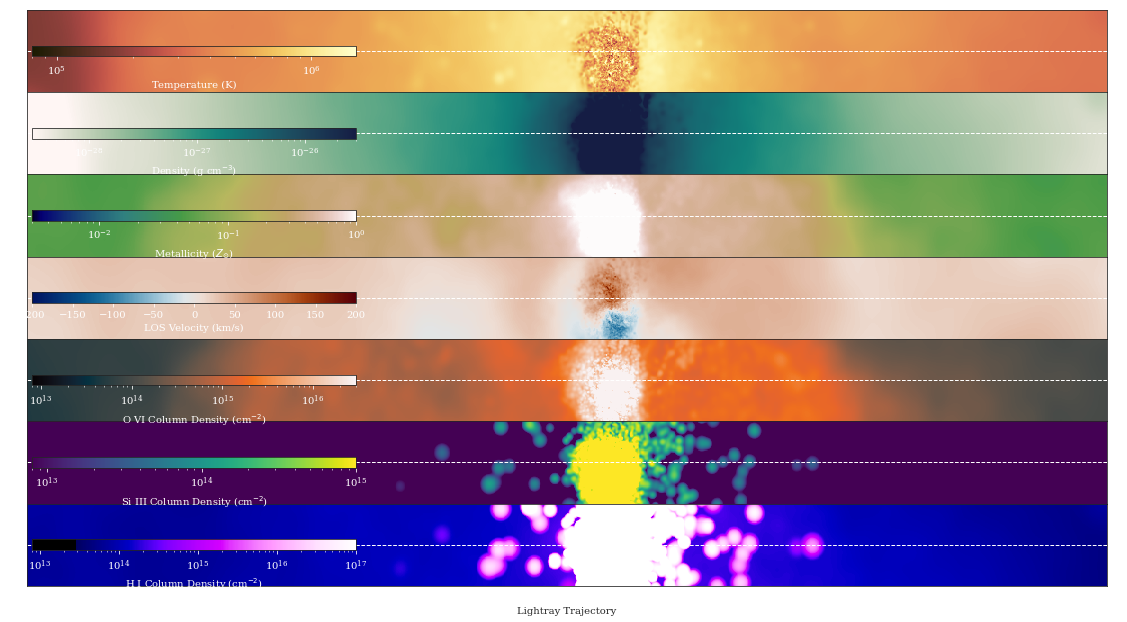

In [13]:
#import matplotlib as mpl
#plt.rcParams.update({"text.usetex":False})
ray_id = 69
model = 'P0'
f = h5.File('../../data/ray_files/ray_image_data_%s_3195_%i.h5'%(model, ray_id), 'r')
#f = h5.File('~/Dropbox/SyntheticSpecCGM/ENZO/data/ray_files/ray_P0_3195_3.h5', 'r')

print(list(f.keys()))
params = {"xtick.color" : "white", 
          "ytick.color" : "white"} 
plt.rcParams.update(params)
field_list = ['temperature', 'density', 'metallicity', 'velocity_los', 
              'O_p5_number_density', 'Si_p2_number_density', 'H_p0_number_density']
zlim_list  = [(8e4, 1.5e6), (3e-29, 3e-26), (3e-3, 1), (-200, 200), (8e12, 3e16),
              (8e12, 1e15), (8e12, 1e17)]
ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'O VI Column Density (cm$^{-2}$)',
                   'Si III Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']

#ylabel_list = field_list

fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (15, 8))
for i, field in enumerate(field_list):
    if field == 'velocity_los':
        vx = np.array(f['velocity_x']) / 1e5
        vy = np.array(f['velocity_y']) / 1e5
        vz = np.array(f['velocity_z']) / 1e5
        ray_direction = end_pos[ray_id] - start_pos[ray_id]
        image = los_vel(vx, vy, vz, bv = [bvx[0], bvy[0], bvz[0]], normal = ray_direction)
        norm = None
    else:
        image = np.array(f[field])
        norm = LogNorm()
    if field == 'metallicity':
        image *= 77.22007722007721  # converting from code units to zsun

    im = ax[i].pcolormesh(image.T, norm = norm, cmap = get_cmap(field),
                          vmin = zlim_list[i][0], vmax = zlim_list[i][1])
    ax[i].axhline(40, linewidth = 1, color = 'white', linestyle = 'dashed')
    cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
    cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
    cbar.set_label(ylabel_list[i], color = 'white')
    
    
    
    
#    cbar = plt.colorbar(im, ax = ax[i], label = ylabel_list[i], pad = 0)
    
#    if i < len(field_list) -1:
#        ax[i].set_xticks([])
#    ax[i].set_yticks([])
    

ax[-1].set_xlabel('Lightray Trajectory')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('../../plots/ray_P0_3195_%i.png'%ray_id, dpi = 300)

In [223]:
f.close()

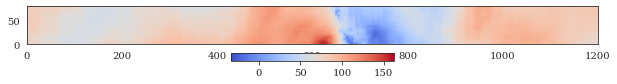

In [167]:
fig, ax = plt.subplots(1, 1, figsize = (20, 1))
im = ax.pcolormesh(vx.T, cmap = 'coolwarm')#, vmin = -200, vmax = 200)
cbar = fig.colorbar(im, ax=ax, orientation = 'horizontal')
ax.set_aspect('equal')
                        

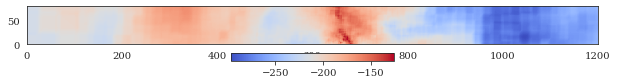

In [168]:
fig, ax = plt.subplots(1, 1, figsize = (20, 1))
im = ax.pcolormesh(vy.T, cmap = 'coolwarm')#, vmin = -200, vmax = 200)
cbar = fig.colorbar(im, ax=ax, orientation = 'horizontal')
ax.set_aspect('equal')

In [13]:
rc = ds.arr([-0.42341276, -0.2998023,   0.13172933], 'unitary')
rs = ds.arr([ 0.00545011, -0.00954593, -0.00594732], 'unitary')
re = ds.arr([0.00749877, 0.00049992, 0.00049992], 'unitary')

rc = [-0.42341276, -0.2998023,   0.13172933]
rs = [ 0.00545011, -0.00954593, -0.00594732]
re = [0.00749877, 0.00049992, 0.00049992]

In [ ]:
rd = 
image = yt.off_axis_projection(ds, rs, rd)

In [6]:
import yt
ds = yt.load('/Users/irynabutsky/simulations/patient0_agncr/pioneer.003195')
#s = yt.SlicePlot(ds, 'z', ('gas', 'density'),width = (100, 'kpc'))
#s.show()

yt : [INFO     ] 2021-01-27 18:54:43,794 Parameters: current_time              = 3.398869692888919e+17 s
yt : [INFO     ] 2021-01-27 18:54:43,794 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-01-27 18:54:43,795 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-01-27 18:54:43,796 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-01-27 18:54:43,796 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-01-27 18:54:43,797 Parameters: current_redshift          = 0.24979488244391623
yt : [INFO     ] 2021-01-27 18:54:43,798 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-01-27 18:54:43,799 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-01-27 18:54:43,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-01-27 18:54:43,799 Parameters: hubble_constant           = 0.677583430663222


yt : [INFO     ] 2021-01-27 18:54:44,431 Allocating for 1.506e+06 particles
Loading particle index:  83%|████████▎ | 5/6 [00:00<00:00, 419.67it/s]
yt : [INFO     ] 2021-01-27 18:54:46,787 xlim = -0.424482 -0.421982
yt : [INFO     ] 2021-01-27 18:54:46,788 ylim = -0.301468 -0.298968
yt : [INFO     ] 2021-01-27 18:54:46,788 xlim = -0.424482 -0.421982
yt : [INFO     ] 2021-01-27 18:54:46,789 ylim = -0.301468 -0.298968
yt : [INFO     ] 2021-01-27 18:54:46,790 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



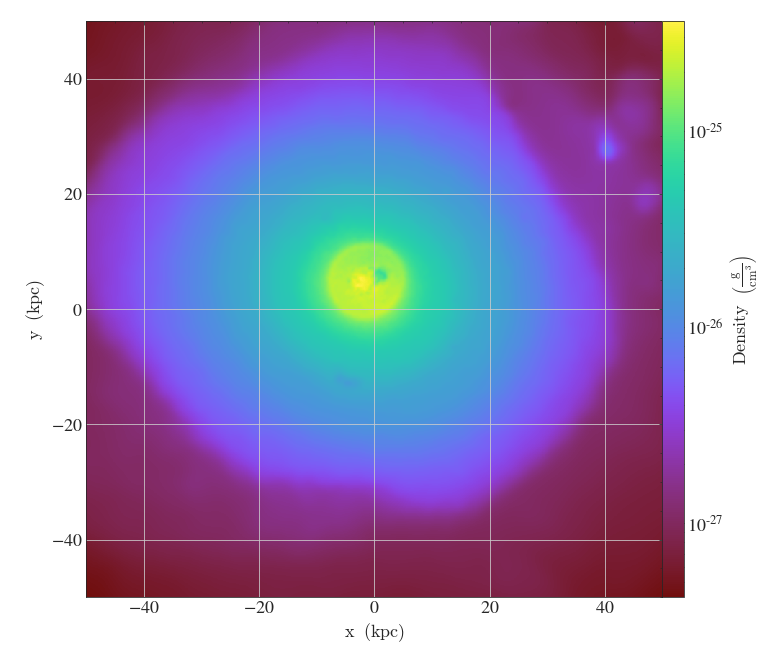

In [7]:
s = yt.SlicePlot(ds, 'z', ('gas', 'density'), center = ds.arr([-0.42323229, -0.30021773,  0.13256167], 'unitary'), 
                 width = (100, 'kpc'))
s.show()

In [7]:
gc = ds.arr([-0.42323229, -0.30021773,  0.13256167], 'unitary')

gc.in_units('kpc')

unyt_array([-16932.07005186, -12010.68008108,   5303.33704603], 'kpc')

In [16]:
ad = ds.all_data()

yt : [INFO     ] 2021-01-27 18:04:21,719 Allocating for 1.506e+06 particles
Loading particle index:  83%|████████▎ | 5/6 [00:00<00:00, 491.39it/s]


In [29]:
r = ds.ray(rs, re)
r[('gas', 'density')]

unyt_array([2.37353102e-30], 'g/cm**3')

In [31]:
(re - rs).in_units('kpc')

unyt_array([ 81.95984912, 401.89994939, 257.93192509], 'kpc')

In [ ]:
s = yt.SlicePlot(ds, 'z', ('gas', 'density'),width = (100, 'kpc'))
s.show()

yt : [INFO     ] 2021-01-27 18:11:51,947 xlim = -0.001250 0.001250
yt : [INFO     ] 2021-01-27 18:11:51,949 ylim = -0.001250 0.001250
yt : [INFO     ] 2021-01-27 18:11:51,950 xlim = -0.001250 0.001250
yt : [INFO     ] 2021-01-27 18:11:51,952 ylim = -0.001250 0.001250
yt : [INFO     ] 2021-01-27 18:11:51,964 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
